# ASSIGNMENT 5 - DANIEL JACK VAN ZYL (MULTI-LABEL CLASSIFICATION)

In [ ]:
# IMPORTS

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multioutput import ClassifierChain
from skmultilearn.adapt import MLkNN
from sklearn.neighbors import NearestNeighbors
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from sklearn.base import clone


# STEP 1. EDA

For the first phase of this analysis, we will look at understanding the data.

In [155]:
# Load the dataset
data = pd.read_csv("scene_train.csv", index_col=0)

# Display the first few rows of the dataset
data.head()

,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,Att10,...,Att291,Att292,Att293,Att294,Class1,Class2,Class3,Class4,Class5,Class6
0,0.646467,0.666435,0.685047,0.699053,0.652746,0.407864,0.150309,0.535193,0.555689,0.580782,...,0.157332,0.247298,0.014025,0.029709,1,0,0,0,1,0
1,0.770156,0.767255,0.761053,0.745630,0.742231,0.688086,0.708416,0.757351,0.760633,0.740314,...,0.251454,0.137833,0.082672,0.036320,1,0,0,0,0,1
2,0.793984,0.772096,0.761820,0.762213,0.740569,0.734361,0.722677,0.849128,0.839607,0.812746,...,0.017166,0.051125,0.112506,0.083924,1,0,0,0,0,0
3,0.938563,0.949260,0.955621,0.966743,0.968649,0.869619,0.696925,0.953460,0.959631,0.966320,...,0.019267,0.031290,0.049780,0.090959,1,0,0,0,0,0
4,0.512130,0.524684,0.520020,0.504467,0.471209,0.417654,0.364292,0.562266,0.588592,0.584449,...,0.198151,0.238796,0.164270,0.184290,1,0,0,0,0,0


So we can see that the data is made up of 294 features, and consists of 6 classes. We can cross-reference with the dataset description to find that the different classes regard different depictions of scenes.

In [180]:
data = data.rename(columns={
    'Class1': 'Beach',
    'Class2': 'Sunset',
    'Class3': 'Fall foliage',
    'Class4': 'Field',
    'Class5': 'Mountain',
    'Class6': 'Urban'
})

### CARDINALITY AND DENSITY

In [182]:
# Extract the label columns
labels = data.iloc[:, -6:]

# Calculate cardinality
cardinality = labels.sum(axis=1).mean()

# Calculate density
num_classes = labels.shape[1]
density = cardinality / num_classes

print(f"Cardinality: {cardinality}, Density: {density}")

Cardinality: 1.0619322873658135, Density: 0.1769887145609689


So we can see that the cardinality is very low, meaning that this problem is mostly similar to a normal single target problem. We can also then imagine that the correlations between targets is likely to be quite low because they seldom occur together.

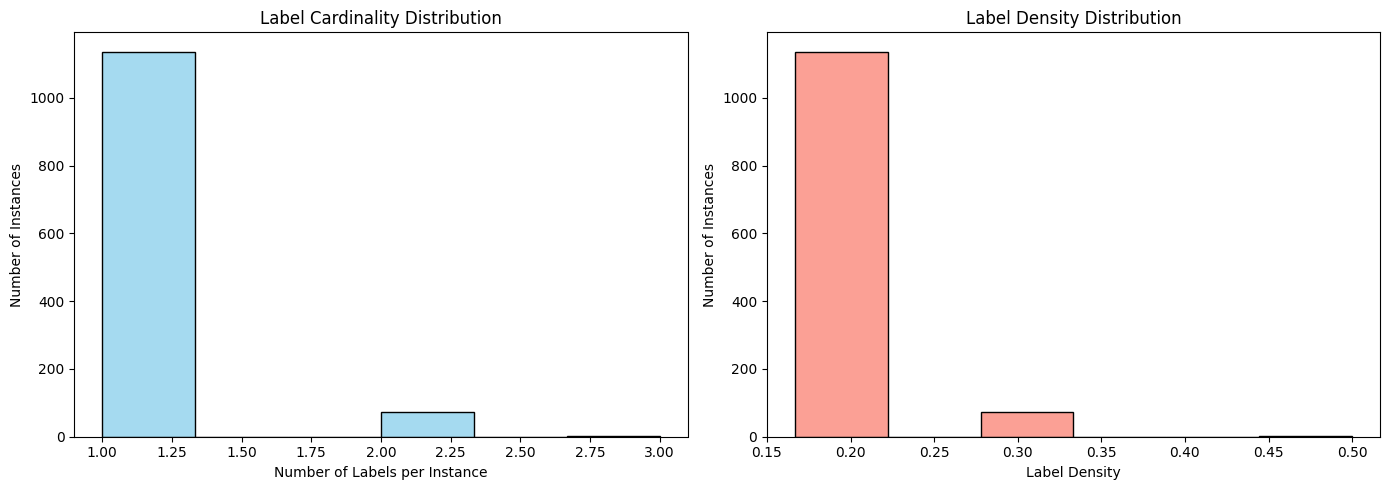

In [184]:
# Calculate Label Cardinality and Density
label_cardinality = labels.sum(axis=1)
label_density = label_cardinality / num_classes

# Plot Label Cardinality Distribution
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.histplot(label_cardinality, bins=num_classes, kde=False, color="skyblue")
plt.title("Label Cardinality Distribution")
plt.xlabel("Number of Labels per Instance")
plt.ylabel("Number of Instances")

# Plot Label Density Distribution
plt.subplot(1, 2, 2)
sns.histplot(label_density, bins=num_classes, kde=False, color="salmon")
plt.title("Label Density Distribution")
plt.xlabel("Label Density")
plt.ylabel("Number of Instances")

plt.tight_layout()
plt.show()

### LABEL IMBALANCE

In [183]:
# Calculate within-label balance
within_label_balance = labels.sum(axis=0) / len(labels)

print("Within Label Balance")
print(within_label_balance)

Within Label Balance
Beach           0.187448
Sunset          0.136251
Fall foliage    0.162675
Field           0.161850
Mountain        0.228737
Urban           0.184971
dtype: float64


So we can generally see here that the within label balance is fairly similar across the different scene types. There is only a small difference here an there. The most well balanced target being Mountain, and the least well balanced being Sunset. NOTE: I am only looking at the training set here, to minimize data implicit leakage.

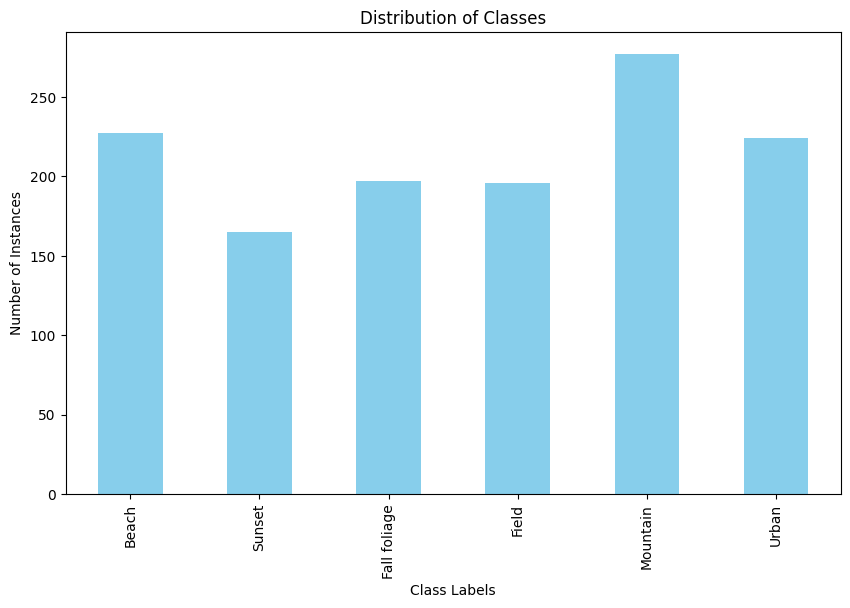

In [185]:
# Plot the distribution of classes
label_sums = labels.sum(axis=0)
plt.figure(figsize=(10, 6))
label_sums.plot(kind='bar', color='skyblue')
plt.title("Distribution of Classes")
plt.ylabel("Number of Instances")
plt.xlabel("Class Labels")
plt.show()

### LABEL DEPENDENCE

In the context of multi-label classification, a co-occurrence matrix captures how often two labels (or classes) appear together on the same instance. In other words, it gives insight into which labels tend to be assigned together. The co-occurrence matrix for this dataset, in terms of the class IDs is given below:

In [186]:
# Calculate between-label balance (co-occurrence matrix)
co_occurrence_matrix = np.dot(labels.T, labels)

# Normalize by the number of instances to get proportions
co_occurrence_matrix = co_occurrence_matrix / len(labels)

co_occurrence_df = pd.DataFrame(co_occurrence_matrix)
co_occurrence_df

,0,1,2,3,4,5
0,0.187448,0.000000,0.000000,0.000000,0.017341,0.009909
1,0.000000,0.136251,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.162675,0.006606,0.004955,0.000000
3,0.000000,0.000000,0.006606,0.161850,0.022296,0.000826
4,0.017341,0.000000,0.004955,0.022296,0.228737,0.000826
5,0.009909,0.000000,0.000000,0.000826,0.000826,0.184971


From this we can see that the diagonal elements represent the probability of each individual label occurring by itself. The off-diagonal values give the probability of two labels co-occurring. It is clear that it is quite a sparse matrix, with many zeros, meaning there are many label pairs that never co-occur. Label 4 (Mountain) seems to co-occur with many other labels, especially with Label 3 and Label 1. However, the second label (Fall foliage) seems to be relatively isolated, as it rarely co-occurs with other labels. Another way to represent these relationship is the correlation matrix given below:

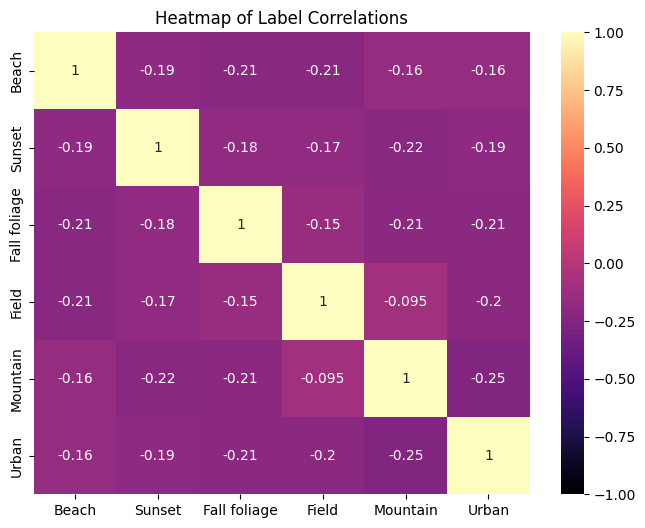

In [189]:
# Compute the pairwise Pearson correlation between labels
label_correlation = labels.corr()

# Plot the heatmap for label correlations
plt.figure(figsize=(8, 6))
sns.heatmap(label_correlation, annot=True, cmap="magma", center=0, vmin=-1, vmax=1)
plt.title("Heatmap of Label Correlations")
plt.show()

As previously theorized, the correlation between targets is very low - indicating that targets do not tend to coincide. As a final measure, we can also attempt to understand the relationship between the features and the targets in the correlation heatmap given below:

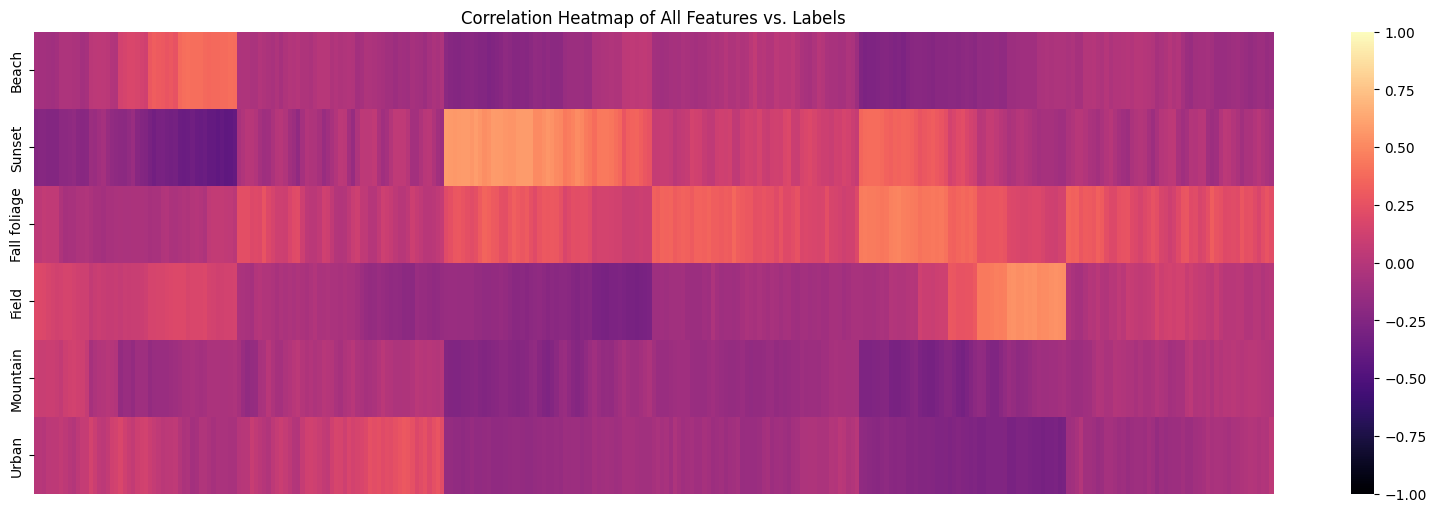

In [188]:
# Calculate the correlation between all features and labels
all_features = data.iloc[:, 1:-6]
correlation_matrix_all = all_features.apply(lambda x: labels.corrwith(x), axis=0)

# Plot heatmap without annotations for a more compact view
plt.figure(figsize=(20, 6))
sns.heatmap(correlation_matrix_all, cmap="magma", center=0, vmin=-1, vmax=1, cbar=True, xticklabels=False, yticklabels=True)
plt.title("Correlation Heatmap of All Features vs. Labels")
plt.show()

It should be noted here that the dataset features are comprised of a 49x49 grid of the transformed colour space of the original images. For each cell in the grid (and for each of the three colour bands), the mean and standard deviation are used as the supplied features.

Looking at the correlation heatmap, it is interesting to see the visual representation of these features. The block like nature reflects the mean and standard deviation of the 3 colour bands (making 6 types). We can see that different scenes show different correlation gradients dependent on these features extracted from the 49 cells.

### DISTRIBUTION OF FEATURES

As a last (and mostly for fun measure), I plot the PCA and t-SNE 2-dimensional representations to just see more or less how the features are mapped.

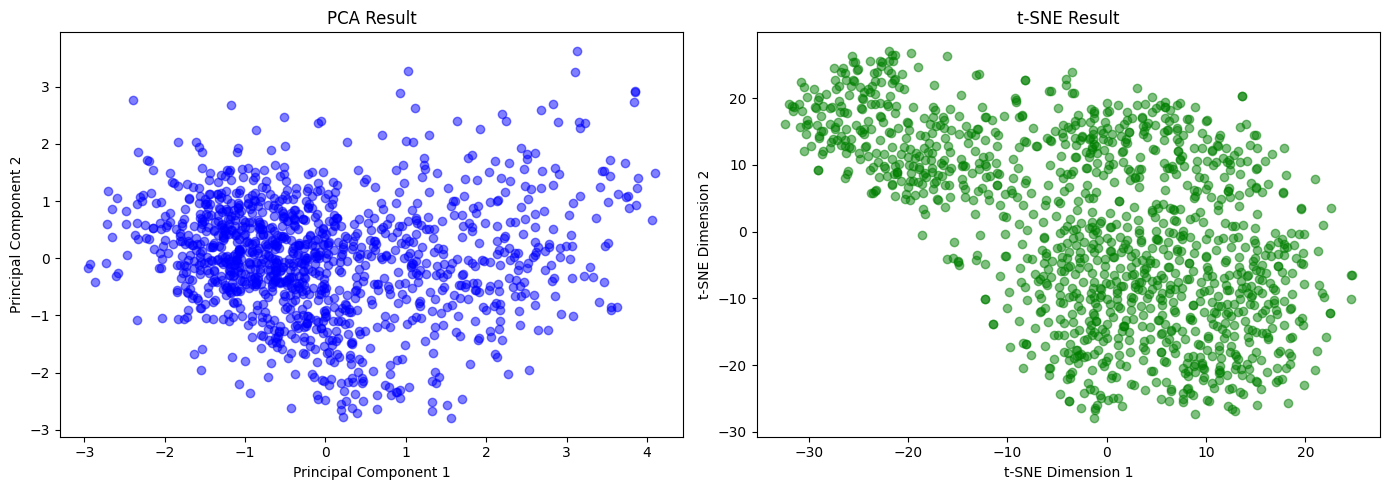

In [163]:
# Extract the features
features = data.iloc[:, 1:-6]

# Apply PCA and reduce to 2 components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)

# Apply t-SNE and reduce to 2 components
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(features)

# Plot PCA and t-SNE results side by side
plt.figure(figsize=(14, 5))

# PCA plot
plt.subplot(1, 2, 1)
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5, color='blue')
plt.title("PCA Result")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# t-SNE plot
plt.subplot(1, 2, 2)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.5, color='green')
plt.title("t-SNE Result")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")

plt.tight_layout()
plt.show()

# STEP 2. METRICS

The following section details the metrics considered for this analysis. Each metric from the notes is included. I didn't think it necessary to give a breakdown of each metric here, but they are implemented, and divided into example based and label based.

## 2.1 Example Based Metrics

In [164]:

from sklearn.metrics import accuracy_score
import numpy as np

def subset_accuracy(y_true, y_pred):
    """
    Compute the Subset Accuracy (Exact Match Ratio) for multi-label classification.
    
    Parameters:
    - y_true: True labels matrix (N x K)
    - y_pred: Predicted labels matrix (N x K)
    
    Returns:
    - Subset Accuracy
    """
    return np.mean(np.all(y_true == y_pred, axis=1))

def hamming_loss(y_true, y_pred):
    """
    Compute the Hamming loss.
    
    Parameters:
    - y_true: True labels matrix (N x K)
    - y_pred: Predicted labels matrix (N x K)
    
    Returns:
    - Hamming loss
    """
    N, K = y_true.shape
    loss = (1 / (N * K)) * np.sum(np.abs(y_true - y_pred))
    return loss

def jaccard_accuracy(y_true, y_pred):
    """
    Compute the Jaccard-based Accuracy for multi-label classification.
    
    Parameters:
    - y_true: True labels matrix (N x K)
    - y_pred: Predicted labels matrix (N x K)
    
    Returns:
    - Jaccard-based Accuracy
    """
    # Compute the intersections and unions for each instance
    intersection = np.logical_and(y_true, y_pred).sum(axis=1)
    union = np.logical_or(y_true, y_pred).sum(axis=1)
    
    # Compute the Jaccard similarity for each instance
    jaccard_similarity = intersection / union
    
    # Return the average Jaccard similarity (Accuracy)
    return jaccard_similarity.mean()

def get_example_based_report(y_true, y_pred):
    """
    Print a multi-label classification report.
    
    Parameters:
    - y_true: True labels matrix (N x K)
    - y_pred: Predicted labels matrix (N x K)
    """
    
    # Compute metrics
    subset_acc = subset_accuracy(y_true, y_pred)
    hamming = hamming_loss(y_true, y_pred)
    jaccard_acc = jaccard_accuracy(y_true, y_pred)
    
    # Print report
    print("Example Based Classification Report:")
    print("-" * 50)
    print(f"Hamming Loss: {hamming:.4f}")
    print(f"Jaccard-based Accuracy: {jaccard_acc:.4f}")
    print(f"Subset Accuracy (Exact Match Ratio): {subset_acc:.4f}")
    print("-" * 50)
    return hamming, jaccard_acc, subset_acc

## 2.2 Label Based Metrics

In [165]:
def label_based_metrics(y_true, y_pred):
    """
    Compute Macro and Micro averaged Precision, Recall, and F-score for multi-label classification.
    
    Parameters:
    - y_true: True labels matrix (N x K)
    - y_pred: Predicted labels matrix (N x K)
    
    Returns:
    - Macro and Micro Precision, Recall, F-score
    """
    
    # True Positives
    TP = np.logical_and(y_pred == 1, y_true == 1).sum(axis=0)
    # False Positives
    FP = np.logical_and(y_pred == 1, y_true == 0).sum(axis=0)
    # False Negatives
    FN = np.logical_and(y_pred == 0, y_true == 1).sum(axis=0)
    
    # Macro Precision, Recall
    macro_precision = np.mean([tp / (tp + fp) if (tp + fp) != 0 else 0 for tp, fp in zip(TP, FP)])
    macro_recall = np.mean([tp / (tp + fn) if (tp + fn) != 0 else 0 for tp, fn in zip(TP, FN)])
    
    # Macro F-score
    macro_f_score = 2 * macro_precision * macro_recall / (macro_precision + macro_recall) if (macro_precision + macro_recall) != 0 else 0
    
    # Micro Precision, Recall, F-score
    micro_precision = TP.sum() / (TP.sum() + FP.sum()) if (TP.sum() + FP.sum()) != 0 else 0
    micro_recall = TP.sum() / (TP.sum() + FN.sum()) if (TP.sum() + FN.sum()) != 0 else 0
    micro_f_score = 2 * micro_precision * micro_recall / (micro_precision + micro_recall) if (micro_precision + micro_recall) != 0 else 0
    
    return macro_precision, macro_recall, macro_f_score, micro_precision, micro_recall, micro_f_score


def get_label_based_metrics_report(y_true, y_pred):
    """
    Print a report for Macro and Micro averaged Precision, Recall, and F-score in multi-label classification.
    
    Parameters:
    - y_true: True labels matrix (N x K)
    - y_pred: Predicted labels matrix (N x K)
    """
    
    # Compute metrics using the `label_based_metrics` function
    macro_precision, macro_recall, macro_f_score, micro_precision, micro_recall, micro_f_score = label_based_metrics(y_true, y_pred)
    
    # Print report
    print("Label-based Metrics Report:")
    print("-" * 50)
    print(f"Macro Precision: {macro_precision:.4f}")
    print(f"Macro Recall: {macro_recall:.4f}")
    print(f"Macro F1-score: {macro_f_score:.4f}")
    print("-" * 50)
    print(f"Micro Precision: {micro_precision:.4f}")
    print(f"Micro Recall: {micro_recall:.4f}")
    print(f"Micro F1-score: {micro_f_score:.4f}")
    print("-" * 50)
    return macro_precision, macro_recall, macro_f_score, micro_precision, micro_recall, micro_f_score


## 2.3 For Reporting

In [166]:
def evaluate(y_true, y_pred):
    macro_precision, macro_recall, macro_f_score, micro_precision, micro_recall, micro_f_score = get_label_based_metrics_report(y_true, y_pred)
    hamming, jaccard_acc, subset_acc = get_example_based_report(y_true, y_pred)
    return hamming, jaccard_acc, subset_acc, macro_precision, macro_recall, macro_f_score, micro_precision, micro_recall, micro_f_score

def save_to_dataframe(model_name, y_true, y_pred):
    metrics = evaluate(y_true, y_pred)
    
    # Create a dictionary with metrics
    metrics_dict = {
        'Model Name': model_name,
        'Hamming': metrics[0],
        'Jaccard Accuracy': metrics[1],
        'Subset Accuracy': metrics[2],
        'Macro Precision': metrics[3],
        'Macro Recall': metrics[4],
        'Macro F-Score': metrics[5],
        'Micro Precision': metrics[6],
        'Micro Recall': metrics[7],
        'Micro F-Score': metrics[8]
    }
    
    # Convert dictionary to dataframe
    df = pd.DataFrame([metrics_dict])
    
    return df


# STEP 3. MODELLING

For the modelling stage, I chose to evaluate 2 models from each modelling type (transformations, algorithmic adaptations and ensemble methods). The models are presented in the following sections. First I read in the test data to evaluate. Also very important to note, I standard scaled the data as a general safety measure, especially considering I'm planning on using kNN which makes use of distance calculations.

In [167]:
# Load in Test Data
test_data = pd.read_csv('scene_test.csv', index_col=0)

# Splitting the features and labels
X_test = test_data.iloc[:, :294] # Feature columns
y_test = test_data.iloc[:, 294:] # Label columns

In [168]:
# Splitting the features and labels
X_train = data.iloc[:, :294] # Feature columns
y_train = data.iloc[:, 294:] # Label columns

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

## 3.1 Problem Transformation Methods

For both of the problem transformation methods, I used a random forest classifier as the base estimator. I used 100 trees in each forest. The logic behind this approach was simply that I found it more important to be consistent for comparison, knowing that I'm also going to be using ensembles later, than to squeeze out every drop of performance and incur large computational costs.

### 3.1.1 Binary Relevance

I implemented binary relevance using Scikit learns multi output classifier.

In [170]:
# Using RandomForestClassifier as an example classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
multi_target_classifier = MultiOutputClassifier(classifier, n_jobs=-1)
multi_target_classifier.fit(X_train, y_train)

# Predict on the test data
y_pred = multi_target_classifier.predict(X_test)

results = save_to_dataframe(y_true=y_test, y_pred=y_pred, model_name="Binary Relevance")

Label-based Metrics Report:
--------------------------------------------------
Macro Precision: 0.9023
Macro Recall: 0.5647
Macro F1-score: 0.6946
--------------------------------------------------
Micro Precision: 0.9140
Micro Recall: 0.5566
Micro F1-score: 0.6919
--------------------------------------------------
Example Based Classification Report:
--------------------------------------------------
Hamming Loss: 0.0897
Jaccard-based Accuracy: 0.5669
Subset Accuracy (Exact Match Ratio): 0.5368
--------------------------------------------------


### 3.1.2 Classifier Chain

I implemented classifier chains according to Scikit learn's Classifier chain

In [171]:
# Using RandomForestClassifier as an example classifier
base_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Creating a Classifier Chain
chain = ClassifierChain(base_classifier, order='random', random_state=42)
chain.fit(X_train, y_train)

# Predict on the test data
y_pred = chain.predict(X_test)

new_results = save_to_dataframe(y_true=y_test, y_pred=y_pred, model_name="Classifier Chain")
results = pd.concat([results, new_results], ignore_index=True)

Label-based Metrics Report:
--------------------------------------------------
Macro Precision: 0.9020
Macro Recall: 0.5714
Macro F1-score: 0.6996
--------------------------------------------------
Micro Precision: 0.9095
Micro Recall: 0.5651
Micro F1-score: 0.6971
--------------------------------------------------
Example Based Classification Report:
--------------------------------------------------
Hamming Loss: 0.0889
Jaccard-based Accuracy: 0.5765
Subset Accuracy (Exact Match Ratio): 0.5477
--------------------------------------------------


## 3.2 Algorithmic Adaptation Methods

### 3.2.1 k-Nearest Neighbours

I implemented the k-NN algorithm using a Python package that directly models the work of Zhang and Zhou (2007). To decide upon the values for k and the smoothing parameter I used 5-fold cross validation. The code and results are given in assignment_5 extra, I found that the smoothing parameter played an insignificant role, and that optimal performance could be obtained as early as 10 neighbours.

In [173]:
knn_classifier = MLkNN(k=10)

knn_classifier.fit(X_train, y_train)

y_pred = knn_classifier.predict(X_test).toarray()

new_results = save_to_dataframe(y_true=y_test, y_pred=y_pred, model_name="k-Nearest Neighbours")
results = pd.concat([results, new_results], ignore_index=True)

Label-based Metrics Report:
--------------------------------------------------
Macro Precision: 0.7722
Macro Recall: 0.7022
Macro F1-score: 0.7356
--------------------------------------------------
Micro Precision: 0.7525
Micro Recall: 0.6998
Micro F1-score: 0.7252
--------------------------------------------------
Example Based Classification Report:
--------------------------------------------------
Hamming Loss: 0.0960
Jaccard-based Accuracy: 0.6761
Subset Accuracy (Exact Match Ratio): 0.6095
--------------------------------------------------


The second algorithmic adaptation I considered was a modified decision tree. Fortunately Scikit learn's decision trees are able to handle multi-output. I used cross validation to decide on tree depth and pruning regularization, and found a depth of 5 to be optimal with no pruning. I used entropy as a criterion, as detailed in the notes.

In [174]:
# Create a multi-output classifier with a decision tree
tree = DecisionTreeClassifier(splitter='random', criterion='entropy', max_depth=5)
tree.fit(X_train, y_train)

# Predict
y_pred = tree.predict(X_test)

new_results = save_to_dataframe(y_true=y_test, y_pred=y_pred, model_name="Decision Tree")
results = pd.concat([results, new_results], ignore_index=True)

Label-based Metrics Report:
--------------------------------------------------
Macro Precision: 0.5725
Macro Recall: 0.4312
Macro F1-score: 0.4919
--------------------------------------------------
Micro Precision: 0.6865
Micro Recall: 0.4180
Micro F1-score: 0.5196
--------------------------------------------------
Example Based Classification Report:
--------------------------------------------------
Hamming Loss: 0.1399
Jaccard-based Accuracy: 0.4293
Subset Accuracy (Exact Match Ratio): 0.4047
--------------------------------------------------


## 3.3 Ensemble Based Methods

For the ensemble based methods, I considered ensembles of binary relevance classifiers and of classifier chains. The implementations follow from the guidelines specified in the notes. I use a threshold equal to half the number of trials for each target class. I used the same base classifier setup for the underlying methods as in 3.1. For each ensemble, I used 10 repeats/trials. I found that going beyond 10 members did not boost performance significantly.

### 3.3.1 Ensemble of Binary Relevance Classifiers

In [175]:
def ensemble_binary_relevance(base_classifier, B, X_train, y_train, X_test):
    # 1. Bootstrap Replication and Training
    classifiers = []
    for _ in range(B):
        X_sample, y_sample = resample(X_train, y_train)
        clf = clone(base_classifier)
        clf.fit(X_sample, y_sample)
        classifiers.append(clf)

    # 2. Predicting New Cases
    predictions = []
    threshold = B // 2
    for k in range(y_train.shape[1]):  # For each label
        label_preds = []
        for clf in classifiers:
            label_pred = clf.predict(X_test)[:, k]
            label_preds.append(label_pred)
        label_preds = np.array(label_preds)

        # 3. Aggregate Predictions using the common threshold
        final_pred = (label_preds.sum(axis=0) >= threshold).astype(int)
        predictions.append(final_pred)

    return np.array(predictions).T

base_classifier = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
B = 10

y_pred = ensemble_binary_relevance(base_classifier, B, X_train, y_train, X_test)

new_results = save_to_dataframe(y_true=y_test, y_pred=y_pred, model_name="Binary Relevance Ensemble")
results = pd.concat([results, new_results], ignore_index=True)

Label-based Metrics Report:
--------------------------------------------------
Macro Precision: 0.8455
Macro Recall: 0.6264
Macro F1-score: 0.7196
--------------------------------------------------
Micro Precision: 0.8440
Micro Recall: 0.6205
Micro F1-score: 0.7152
--------------------------------------------------
Example Based Classification Report:
--------------------------------------------------
Hamming Loss: 0.0895
Jaccard-based Accuracy: 0.6086
Subset Accuracy (Exact Match Ratio): 0.5552
--------------------------------------------------


### 3.3.2 Ensemble of Chain Classifiers

In [176]:
def ensemble_classifier_chains(base_classifier, M, X_train, y_train, X_test, t):
    num_labels = y_train.shape[1]
    
    # 1. Random Ordering of Labels and 2. Bootstrap Replication
    chains = []
    for _ in range(M):
        order = np.random.permutation(num_labels)
        X_sample, y_sample = resample(X_train, y_train)
        
        # 3. Train Classifier Chains
        chain = ClassifierChain(base_classifier, order=order)
        chain.fit(X_sample, y_sample)
        chains.append(chain)
    
    # 4. Predicting New Cases
    predictions = []
    for k in range(num_labels):  # For each label
        label_preds = []
        for chain in chains:
            label_pred = chain.predict(X_test)[:, k]
            label_preds.append(label_pred)
        label_preds = np.array(label_preds)

        # Aggregate Predictions using threshold t
        final_pred = (label_preds.sum(axis=0) >= t).astype(int)
        predictions.append(final_pred)
        
    return np.array(predictions).T

# Example usage:
base_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
M = 10
t = M // 2  # Setting threshold to half of M

y_pred = ensemble_classifier_chains(base_classifier, M, X_train, y_train, X_test, t)

new_results = save_to_dataframe(y_true=y_test, y_pred=y_pred, model_name="Classifier Chain Ensemble")
results = pd.concat([results, new_results], ignore_index=True)

Label-based Metrics Report:
--------------------------------------------------
Macro Precision: 0.8568
Macro Recall: 0.6468
Macro F1-score: 0.7372
--------------------------------------------------
Micro Precision: 0.8571
Micro Recall: 0.6420
Micro F1-score: 0.7342
--------------------------------------------------
Example Based Classification Report:
--------------------------------------------------
Hamming Loss: 0.0842
Jaccard-based Accuracy: 0.6360
Subset Accuracy (Exact Match Ratio): 0.5895
--------------------------------------------------


# Step 4. Results

In [177]:
results

,Model Name,Hamming,Jaccard Accuracy,Subset Accuracy,Macro Precision,Macro Recall,Macro F-Score,Micro Precision,Micro Recall,Micro F-Score
0,Binary Relevance,0.089744,0.566890,0.536789,0.902269,0.564689,0.694637,0.914033,0.556582,0.691866
1,Classifier Chain,0.088907,0.576505,0.547659,0.902043,0.571389,0.699615,0.909542,0.565050,0.697056
2,k-Nearest Neighbours,0.096014,0.676143,0.609532,0.772239,0.702225,0.735570,0.752483,0.699769,0.725170
3,Decision Tree,0.139911,0.429348,0.404682,0.572509,0.431222,0.491922,0.686473,0.418014,0.519617
4,Binary Relevance Ensemble,0.089465,0.608556,0.555184,0.845452,0.626419,0.719638,0.843979,0.620477,0.715173
5,Classifier Chain Ensemble,0.084169,0.636009,0.589465,0.856835,0.646813,0.737157,0.857143,0.642032,0.734155


From the results, we can see that there is no clear model winner. We can also see that different metrics highlight different traits. In general classifier chains tended to do better than binary relevance (which makes sense), and ensembles further boosted performance, but not by much at all. Precision was frequently higher than recall for all models, and the kNN model had the best F1-scores, noting that the balance between precision and recall was better for the kNN classifier. To view the relative performance better, I present two plots, the first for all metrics except hamming loss, and then for hamming loss.

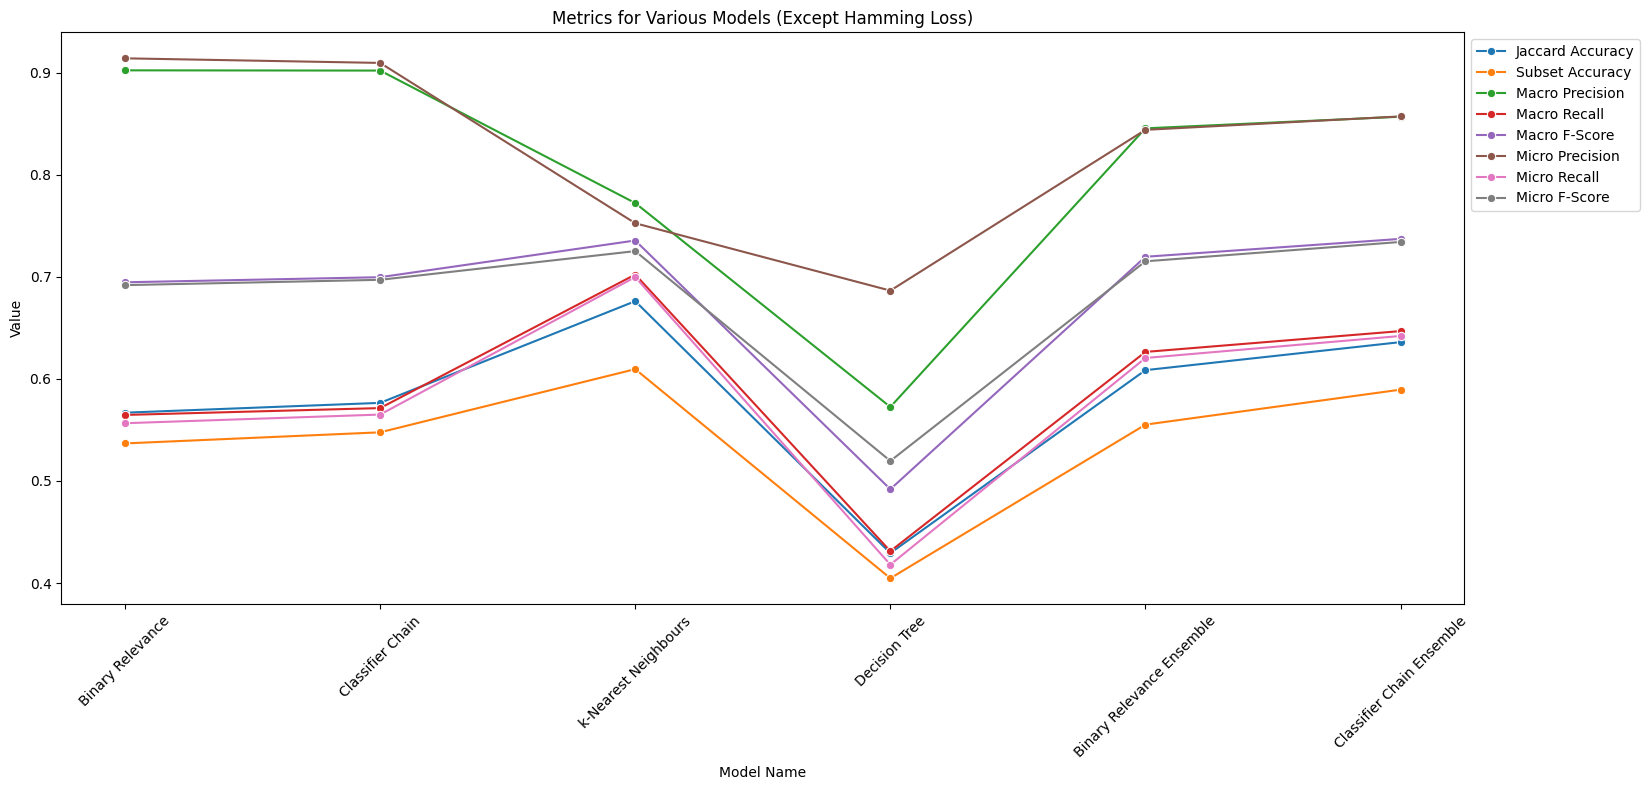

In [178]:
df_melted = results.melt(id_vars='Model Name', value_vars=results.columns[2:], var_name='Metrics', value_name='Value')

plt.figure(figsize=(15, 8))
sns.lineplot(data=df_melted, x='Model Name', y='Value', hue='Metrics', marker="o")
plt.xticks(rotation=45)
plt.title('Metrics for All Models (Except Hamming Loss)')
plt.tight_layout()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

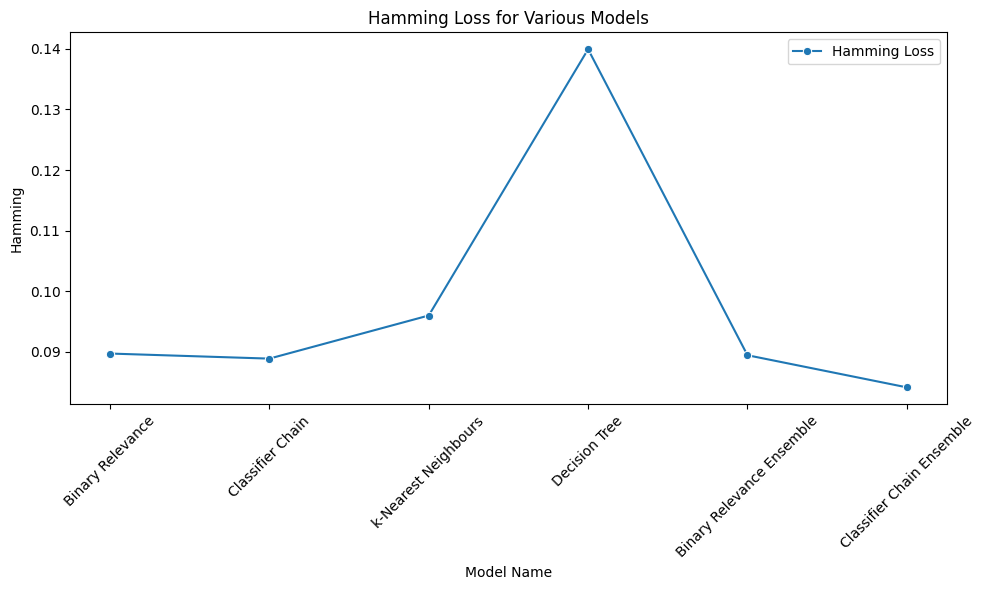

In [179]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=results, x='Model Name', y='Hamming', marker="o", label='Hamming Loss')
plt.xticks(rotation=45)
plt.title('Hamming Loss for All Models')
plt.tight_layout()
plt.show()

These plots give a better idea of overall model behaviours. We can see that the k-NN and decision tree models typically have higher hamming loss. Across all metrics, it should be noted that the decision tree performed particularly poorly. This is likely because single decision trees are limited in their flexibility and power. The kNN model likely performed most admirably overall, with a notable boost in performance across most metrics. The reason that ensembles did not yield significantly better results probably follows from the afformentioned fact that target correlations were very low, meaning that co-dependencies did not need to be addressed as strongly. This is also likely why classifier chains did not result in significantly improved performance, because this problem could mostly be modelled individually for each target. It is interesting to note the relative performance across the different metrics, and further work could be done to really understand why each of these models performed as such for each metric. This would show the difference in metrics quite nicely.